In [ ]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 7.0 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=23b2cd31edc63621c4370713f0ceb885d902b51d5bc03e1932b918156283fd09
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


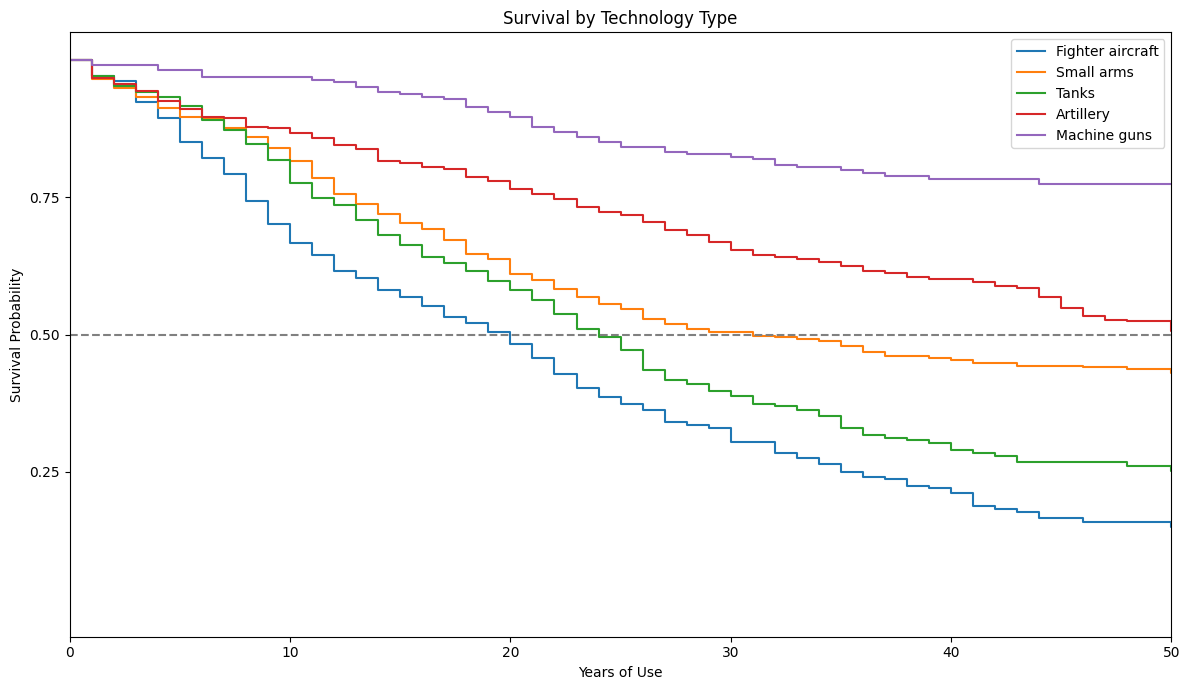

<lifelines.CoxPHFitter: fitted with 983 total observations, 306 right-censored observations>
             duration col = 'duration_years'
                event col = 'event_observed'
      baseline estimation = breslow
   number of observations = 983
number of events observed = 677
   partial log-likelihood = -4170.22
         time fit was run = 2025-05-21 21:55:36 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
is_fighter  0.56      1.75      0.08            0.40            0.71                1.49                2.04

            cmp to    z      p  -log2(p)
covariate                               
is_fighter    0.00 7.02 <0.005     38.67
---
Concordance = 0.57
Partial AIC = 8342.45
log-likelihood ratio test = 49.44 on 1 df
-log2(p) of ll-ratio test = 38.83

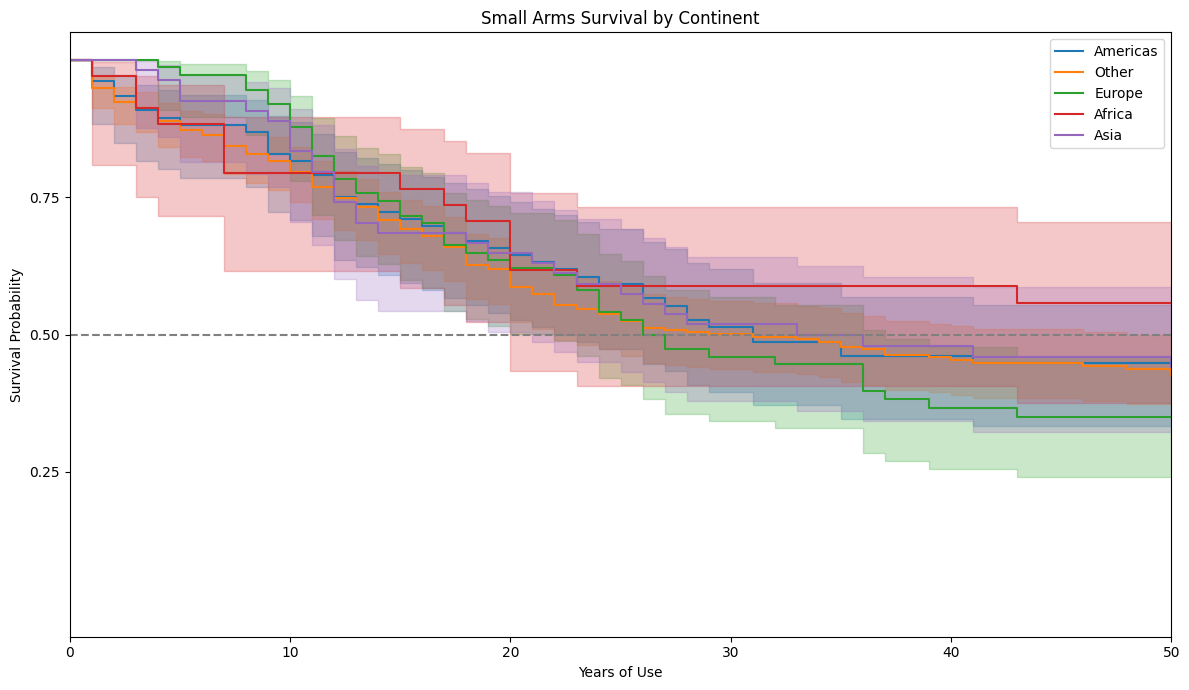

Chi² = 565.57, p = 0.0000


In [ ]:
import pandas as pd

df = pd.read_csv("cow_arms_tech_long.csv")
df = df[df["use"] == 1].copy()
df = df.sort_values(["ccode", "techname", "year"])

# Detect start of each new spell of use
df["used_shift"] = df.groupby(["ccode", "techname"])["use"].shift(1, fill_value=0)
df["new_spell"] = (df["use"] == 1) & (df["used_shift"] != 1)
df["spell_id"] = df.groupby(["ccode", "techname"])["new_spell"].cumsum()

# Collapse to spells (start to end)
spells = df.groupby(["ccode", "techname", "techtype", "spell_id"]).agg(
    start_year=("year", "min"),
    end_year=("year", "max")
).reset_index()

spells["duration_years"] = spells["end_year"] - spells["start_year"] + 1
spells["event_observed"] = (spells["end_year"] < 2023).astype(int)

from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()
top_types = spells["techtype"].value_counts().head(5).index

plt.figure(figsize=(12, 7))
for tech in top_types:
    subset = spells[spells["techtype"] == tech]
    kmf.fit(subset["duration_years"], event_observed=subset["event_observed"], label=tech)
    kmf.plot_survival_function(ci_show=False)

plt.title("Survival by Technology Type")
plt.xlabel("Years of Use")
plt.ylabel("Survival Probability")
plt.xlim(0, 50)
plt.yticks([0.25, 0.5, 0.75])
plt.axhline(0.5, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

subset = spells[spells["techtype"].isin(["Fighter aircraft", "Small arms"])].copy()
subset["is_fighter"] = (subset["techtype"] == "Fighter aircraft").astype(int)

from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(subset[["duration_years", "event_observed", "is_fighter"]],
        duration_col="duration_years", event_col="event_observed")
cph.print_summary()

# Map COW ccode values to continents
def get_continent(ccode):
    if ccode in [402, 403, 404, 411, 420, 432, 434, 435, 436, 437, 438, 439, 450, 451, 452, 461, 471, 475, 482, 490]:
        return "Africa"
    elif ccode in [630, 640, 645, 651, 660, 663, 666, 670, 678, 680, 690, 692, 694, 696, 698, 700, 701, 702, 710, 731, 740, 750]:
        return "Asia"
    elif ccode in [200, 205, 220, 230, 255, 265, 300, 305, 310, 317, 325, 331, 335, 350, 359, 364, 367, 371, 372, 375, 380, 385, 390]:
        return "Europe"
    elif ccode in [2, 20, 40, 42, 51, 52, 70, 90, 91, 95, 100, 110, 115, 130, 135, 140, 145, 155, 160, 165]:
        return "Americas"
    elif ccode in [630, 640, 645, 651, 663, 666, 670, 678, 680]:
        return "Middle East"
    else:
        return "Other"


small_arms = spells[spells["techtype"] == "Small arms"].copy()
small_arms["continent"] = small_arms["ccode"].apply(get_continent)

plt.figure(figsize=(12, 7))
for region in small_arms["continent"].unique():
    subset = small_arms[small_arms["continent"] == region]
    kmf.fit(subset["duration_years"], subset["event_observed"], label=region)
    kmf.plot_survival_function(ci_show=True)

plt.title("Small Arms Survival by Continent")
plt.xlabel("Years of Use")
plt.ylabel("Survival Probability")
plt.xlim(0, 50)
plt.yticks([0.25, 0.5, 0.75])
plt.axhline(0.5, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

from lifelines.statistics import logrank_test

spells["era"] = pd.cut(spells["start_year"],
                       bins=[1823, 1873, 1923, 1973, 2023],
                       labels=["1823–1873", "1873–1923", "1923–1973", "1973–2023"])

group1 = spells[spells["era"] == "1823–1873"]
group2 = spells[spells["era"] == "1973–2023"]

results = logrank_test(group1["duration_years"], group2["duration_years"],
                       event_observed_A=group1["event_observed"],
                       event_observed_B=group2["event_observed"])
print(f"Chi² = {results.test_statistic:.2f}, p = {results.p_value:.4f}")


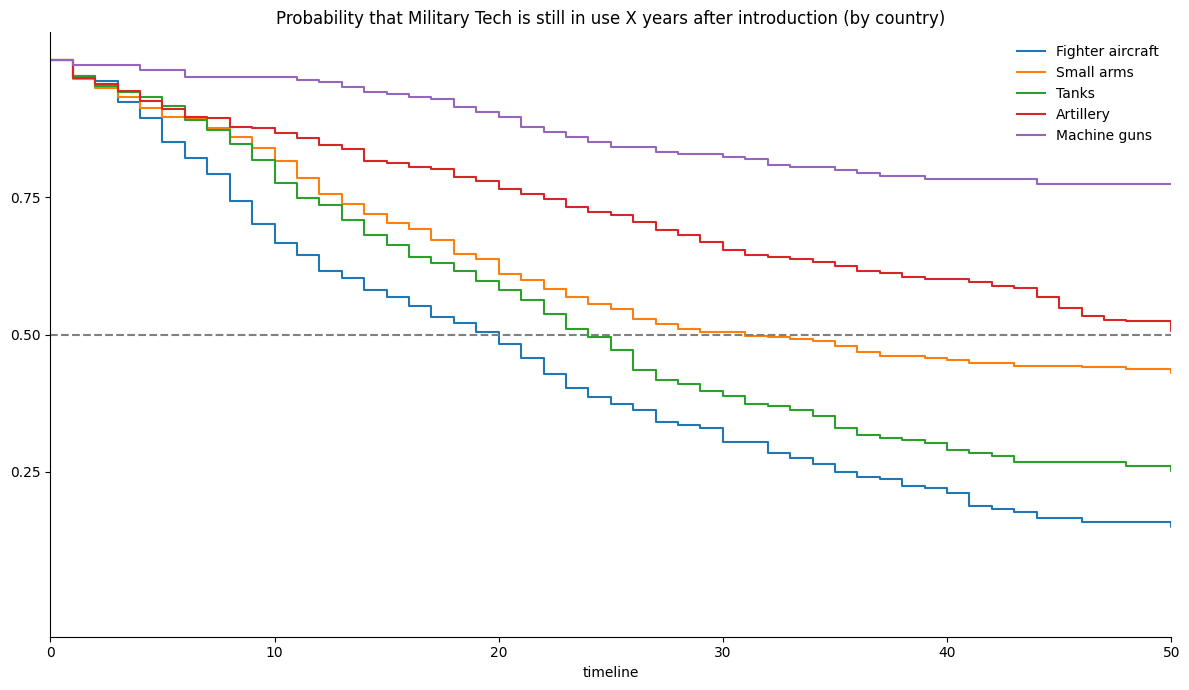

In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()
top_types = spells["techtype"].value_counts().head(5).index

plt.figure(figsize=(12, 7))
for tech in top_types:
    subset = spells[spells["techtype"] == tech]
    kmf.fit(subset["duration_years"], event_observed=subset["event_observed"], label=tech)
    kmf.plot_survival_function(ci_show=False)

plt.title("Probability that Military Tech is still in use X years after introduction (by country)")



plt.xlim(0, 50)
plt.yticks([0.25, 0.5, 0.75])
plt.axhline(0.5, color='gray', linestyle='--')

# Remove top and right spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Remove legend box
plt.legend(frameon=False)

plt.tight_layout()
plt.savefig("survival_plot.png", dpi=300)
plt.show()


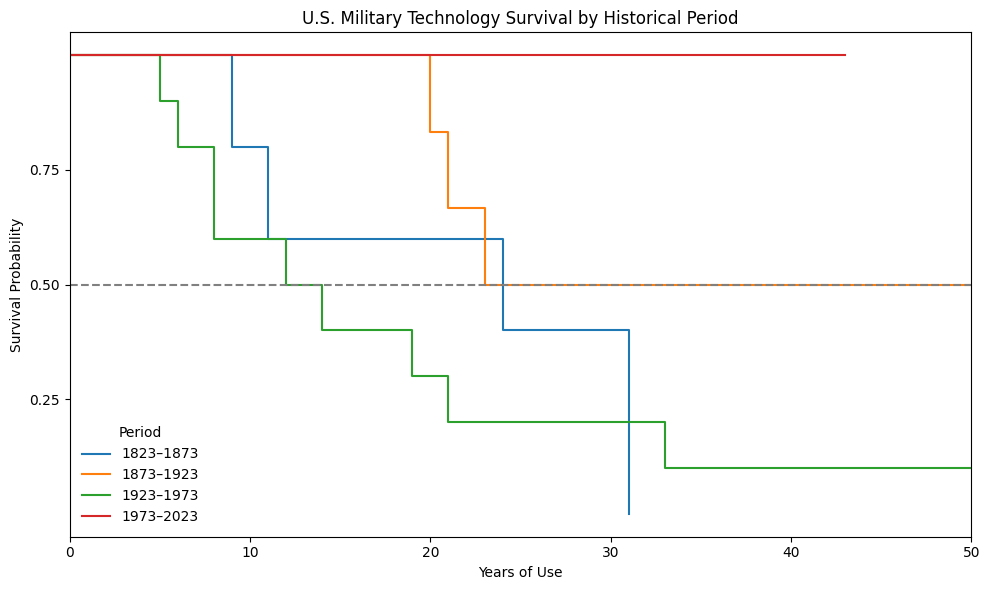

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Load dataset
df = pd.read_csv("cow_arms_tech_long.csv")

# Filter for active use spells
df = df[df["use"] == 1].copy()
df = df.sort_values(["ccode", "techname", "year"])
df["used_shift"] = df.groupby(["ccode", "techname"])["use"].shift(1, fill_value=0)
df["new_spell"] = (df["use"] == 1) & (df["used_shift"] != 1)
df["spell_id"] = df.groupby(["ccode", "techname"])["new_spell"].cumsum()

# Collapse to spells
spells = df.groupby(["ccode", "techname", "spell_id"]).agg(
    start_year=("year", "min"),
    end_year=("year", "max")
).reset_index()

spells["duration_years"] = spells["end_year"] - spells["start_year"] + 1
spells["event_observed"] = (spells["end_year"] < 2023).astype(int)

# Filter for United States
us_spells = spells[spells["ccode"] == 2].copy()

# Assign 50-year period bins
bins = [1823, 1873, 1923, 1973, 2023]
labels = ["1823–1873", "1873–1923", "1923–1973", "1973–2023"]
us_spells["period"] = pd.cut(us_spells["start_year"], bins=bins, labels=labels, right=False)

# Plot Kaplan-Meier survival curves
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))

for period in labels:
    group = us_spells[us_spells["period"] == period]
    if not group.empty:
        kmf.fit(group["duration_years"], event_observed=group["event_observed"], label=period)
        kmf.plot_survival_function(ci_show=False)

plt.title("U.S. Military Technology Survival by Historical Period")
plt.xlabel("Years of Use")
plt.ylabel("Survival Probability")
plt.xlim(0, 50)
plt.yticks([0.25, 0.5, 0.75])
plt.axhline(0.5, color="gray", linestyle="--")
plt.grid(False)
plt.legend(title="Period", frameon=False)
plt.tight_layout()
plt.show()


In [ ]:
# Run pairwise log-rank tests
period_groups = {label: us_spells[us_spells["period"] == label] for label in labels}
logrank_results = []

for i in range(len(labels)):
    for j in range(i+1, len(labels)):
        g1 = period_groups[labels[i]]
        g2 = period_groups[labels[j]]
        result = logrank_test(
            g1["duration_years"], g2["duration_years"],
            event_observed_A=g1["event_observed"],
            event_observed_B=g2["event_observed"]
        )
        logrank_results.append({
            "Period 1": labels[i],
            "Period 2": labels[j],
            "Chi2": result.test_statistic,
            "p-value": result.p_value,
            "-log2(p)": -np.log2(result.p_value) if result.p_value > 0 else float('inf')
        })

logrank_df = pd.DataFrame(logrank_results)
print(logrank_df)


    Period 1   Period 2      Chi2   p-value  -log2(p)
0  1823–1873  1873–1923  1.622260  0.202777  2.302035
1  1823–1873  1923–1973  0.104804  0.746139  0.422483
2  1823–1873  1973–2023  5.531429  0.018678  5.742528
3  1873–1923  1923–1973  4.354609  0.036909  4.759886
4  1873–1923  1973–2023  1.842568  0.174650  2.517459
5  1923–1973  1973–2023  6.313028  0.011985  6.382578


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

# Load and preprocess the dataset
df = pd.read_csv("cow_arms_tech_long.csv")
df = df[df["use"] == 1].copy()
df = df.sort_values(["ccode", "techname", "year"])
df["used_shift"] = df.groupby(["ccode", "techname"])["use"].shift(1, fill_value=0)
df["new_spell"] = (df["use"] == 1) & (df["used_shift"] != 1)
df["spell_id"] = df.groupby(["ccode", "techname"])["new_spell"].cumsum()

# Collapse to spells
spells = df.groupby(["ccode", "techname", "techtype", "spell_id"]).agg(
    start_year=("year", "min"),
    end_year=("year", "max")
).reset_index()

spells["duration_years"] = spells["end_year"] - spells["start_year"] + 1
spells["event_observed"] = (spells["end_year"] < 2023).astype(int)

# Define NATO and Africa by ccode
nato_ccodes = [2, 20, 40, 42, 51, 70, 90, 200, 205, 220, 230, 255, 300, 305, 310, 317, 325, 350, 352]
africa_ccodes = [402, 403, 404, 411, 420, 432, 434, 435, 436, 437, 438, 439, 450, 451, 452, 461, 471, 475, 482, 490]

# Subset to small arms only and label group
small_arms = spells[spells["techtype"] == "Small arms"].copy()
small_arms["region"] = small_arms["ccode"].apply(
    lambda x: "NATO" if x in nato_ccodes else ("Africa" if x in africa_ccodes else "Other")
)

# Filter to only NATO and Africa
subset = small_arms[small_arms["region"].isin(["NATO", "Africa"])].copy()

# Kaplan-Meier Plot
plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

for region in ["NATO", "Africa"]:
    group = subset[subset["region"] == region]
    kmf.fit(group["duration_years"], event_observed=group["event_observed"], label=region)
    kmf.plot_survival_function(ci_show=False)

plt.title("Probability of Small Arms Still in Use: NATO vs Africa")
plt.xlabel("Years of Use")
plt.xlim(0, 50)
plt.yticks([0.25, 0.5, 0.75])
plt.axhline(0.5, color='gray', linestyle='--')
plt.grid(False)
plt.legend(frameon=False)
plt.tight_layout()
# Remove top and right spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.savefig("small_arms_nato_africa_km.png")
plt.close()

# Encode binary variable for Cox model
subset["is_nato"] = (subset["region"] == "NATO").astype(int)

# Cox Proportional Hazards Model
cph = CoxPHFitter()
cph.fit(subset[["duration_years", "event_observed", "is_nato"]],
        duration_col="duration_years", event_col="event_observed")
summary = cph.summary

# Log-rank test
nato = subset[subset["region"] == "NATO"]
africa = subset[subset["region"] == "Africa"]
logrank = logrank_test(nato["duration_years"], africa["duration_years"],
                       event_observed_A=nato["event_observed"],
                       event_observed_B=africa["event_observed"])

summary_df = summary.reset_index().rename(columns={'index': 'Variable'})
summary_df["logrank_p"] = logrank.p_value
summary_df["logrank_chi2"] = logrank.test_statistic






In [ ]:
summary_df

,covariate,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p),logrank_p,logrank_chi2
0,is_nato,0.457269,1.579754,0.294438,-0.119819,1.034357,0.887081,2.813297,0.0,1.553022,0.120418,3.053878,0.11533,2.479625


In [ ]:
import pandas as pd
from lifelines import KaplanMeierFitter

# Load and preprocess
df = pd.read_csv("cow_arms_tech_long.csv")
df = df[df["use"] == 1].copy()
df = df.sort_values(["ccode", "techname", "year"])
df["used_shift"] = df.groupby(["ccode", "techname"])["use"].shift(1, fill_value=0)
df["new_spell"] = (df["use"] == 1) & (df["used_shift"] != 1)
df["spell_id"] = df.groupby(["ccode", "techname"])["new_spell"].cumsum()

# Summarize spells
spells = df.groupby(["ccode", "techname", "techtype", "spell_id"]).agg(
    start_year=("year", "min"),
    end_year=("year", "max")
).reset_index()

spells["duration_years"] = spells["end_year"] - spells["start_year"] + 1
spells["event_observed"] = (spells["end_year"] < 2023).astype(int)

# NATO and Africa ccodes
nato_ccodes = [2, 20, 40, 42, 51, 70, 90, 200, 205, 220, 230, 255, 300, 305, 310, 317, 325, 350, 352]
africa_ccodes = [402, 403, 404, 411, 420, 432, 434, 435, 436, 437, 438, 439, 450, 451, 452, 461, 471, 475, 482, 490]

# Filter small arms and assign regions
small_arms = spells[spells["techtype"] == "Small arms"].copy()
small_arms["region"] = small_arms["ccode"].apply(
    lambda x: "NATO" if x in nato_ccodes else ("Africa" if x in africa_ccodes else "Other")
)

# Compute median survival
kmf = KaplanMeierFitter()

for region in ["NATO", "Africa"]:
    subset = small_arms[small_arms["region"] == region]
    kmf.fit(subset["duration_years"], event_observed=subset["event_observed"])
    median = kmf.median_survival_time_
    print(f"{region} median survival time: {median:.2f} years")


NATO median survival time: 27.00 years
Africa median survival time: inf years


In [ ]:
# Extend region mapping to include Europe
europe_ccodes = [200, 205, 220, 230, 255, 265, 300, 305, 310, 317, 325, 331, 335, 350, 359, 364, 367, 371, 372, 375, 380, 385, 390]

# Add European region label
small_arms["region"] = small_arms["ccode"].apply(
    lambda x: "NATO" if x in nato_ccodes else (
        "Africa" if x in africa_ccodes else (
            "Europe" if x in europe_ccodes else "Other"
        )
    )
)

# Compute Kaplan-Meier and median survival for Europe
kmf = KaplanMeierFitter()
europe_subset = small_arms[small_arms["region"] == "Europe"]
kmf.fit(europe_subset["duration_years"], event_observed=europe_subset["event_observed"])
median = kmf.median_survival_time_

print(f"Europe median survival time: {median:.2f} years")


Europe median survival time: 36.00 years
